In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
import linear as ln
from sklearn.metrics import confusion_matrix

## Énoncé
Consultant pour Olist, nous devons fournir aux équipes d'e-commerce une segmentation des clients utilisable au quotidien pour leurs campagnes de communication.
## Mission
Nous allons réaliser  des simulation afin de déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.

Lecture du jeu de données:

In [2]:
df_orders = pd.read_csv('df_orders_.csv')

### Filtrage des commandes 

Définissons la derniére date de commandes:

In [4]:
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
max_date = max(df_orders['order_purchase_timestamp'])
max_date

Timestamp('2018-10-17 17:30:18')

Pour une date Ti donnée, définissons une fonction  qui permette de génerer le dataframe RFM des clients ayant effectués les commandes jusqu’à la date Ti. 

In [5]:
def df_period(df, date):
    """Generate the RFM dataframe of customers who have placed orders up to a date.
    Parameters
    ----------
    df : dataframe
    date:  object
           date of order
    Returns
    -------
    df : dataframe
    """
    df_date = pd.DataFrame({'date':pd.date_range(start=date, periods=1)})
    days = (max_date-df_date['date']).dt.days.loc[0]
    mask = (df['nb_days'] >= days)
    df = df[mask]
    df= df.groupby('customer_unique_id').agg({'nb_days': 'min',
                                              'customer_id':'count',
                                              'total_payment':'sum',
                                              'review_score': 'mean',
                                              }).reset_index()
    df.columns = ['customer_id', 'recency', 'frequency', 'monetary',' note']
    return df   

### Simulation d’évolution des clusters

L’objectif est de déterminer au bout de combien de temps le modèle de clustering entraîné initialement proposé devient obsolète nécessitant d’entraîner un nouveau modèle de clustering.

#### Periode initiale

 Fixons notre date initiale en intégrant un délai de simulation de maintenance:

In [6]:
initial_date = '2018-09-05'
initial_date

'2018-09-05'

Définissons le dataframe relatif à la période initiale:

In [7]:
df_intial = df_period(df_orders, initial_date)

Définissons un processeur pour standardiser nos données:

In [8]:
numerical_features = list(df_intial.select_dtypes(include=['int64', 'float64', 'uint8']).columns)
scaler = StandardScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

Définissons le pipeline relatif aux données initiales:

In [9]:
kmeans_pipeline_init = Pipeline([
                                 ("preprocessor", preprocessor),
                                 ("kmeans", KMeans(5))])
kmeans_pipeline_init.fit(df_intial)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['recency', 'frequency',
                                                   'monetary', 'note'])])),
                ('kmeans', KMeans(n_clusters=5))])

#### Simulation

Affichons notre intervalle temporelle:

In [10]:
(pd.to_datetime(initial_date)) - min(df_orders['order_purchase_timestamp'])

Timedelta('730 days 02:44:41')

Fixons le délai entre 2 simulations à 10 jours et etudions la divergence des clusters sur notre intervalle temporelle:

#### ARI

Nous utlisons adjusted_rand_score(ARI) pour mésurer la divergence des clusters dans notre intervalle temporelle:

Définissons une fonction qui génere le dataframe des ARI score:

In [14]:
def ari_score(df):
    """Generate the adjusted_rand_score(ARI) dataframe to measure the divergence of clusters in our time interval.
    Parameters
    ----------
    df : dataframe
        initial dataframe
    Returns
    -------
    df : dataframe
         ARI score dataframe  
    """
    ari_score = []
    for p in range(71) :
        # Create dataset for period
        date = pd.to_datetime(initial_date) + pd.DateOffset(days=-10*p)
        df_p = df_period(df,date)
    
        # K-Means p period 
        kmeans_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("kmeans", KMeans(5))])
        kmeans_pipeline.fit(df_p)
    
        # clusters
        label_p = kmeans_pipeline.named_steps['kmeans'].labels_
        label_0 = kmeans_pipeline_init.predict(df_p)
    
        # Calculate ARI score
        ari_p = adjusted_rand_score(label_0, label_p)
        ari_score.append([p,ari_p])
    
    # ARI score dataframe 
    df_ari_score = pd.DataFrame(ari_score, columns=['periode', 'ARI'])
    
    return df_ari_score  

Génerons le dataframe:

In [15]:
df_ari_score = ari_score(df_orders)

Visualissons les résultats:

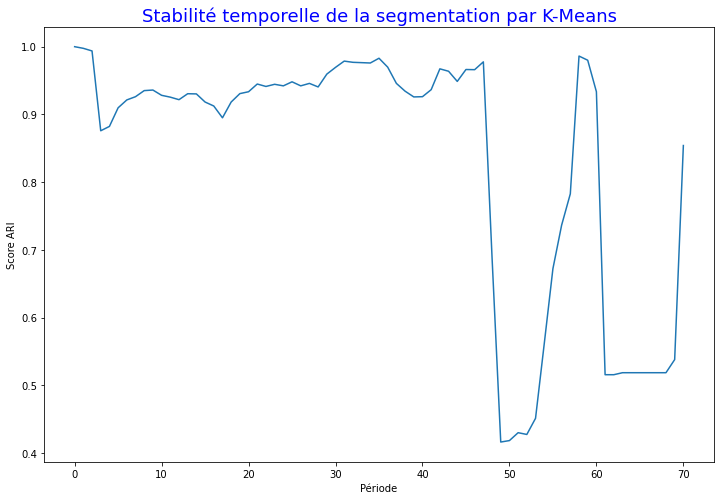

In [18]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=df_ari_score, x="periode", y="ARI")
plt.xlabel("Période")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Affichons la période temporelle où l'ARI est en dessous de 0.8:

In [17]:
df_ari_score.loc[df_ari_score['ARI'] < 0.8].iloc[:5]

,periode,ARI
48,48,0.688745
49,49,0.416288
50,50,0.418438
51,51,0.430077
52,52,0.427473


Des scores ARI obtenus sur des itérations par période de 10jours, on remarque une forte inflexion de l'ARI après 470 jours.

Il faudra donc prévoir la maintenance du programme de segmentation tous les 470 jours dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner.

#### Accuracy

Nous utlisons ici l'accuracy pour mesurer la divergence des clusters dans notre intervalle temporelle:

Définissons une fonction pour réordonner la matrice de confusion:

In [21]:
def _make_cost_m(cm):
    """Function to transform the confusion matrix:.
    Parameters
    ----------
    cm : matrix
        confusion matrix
    Returns
    -------
    - cm + s : matrix
         confusion matrix transformed  
    """
    s = np.max(cm)
    return (- cm + s)

Calculons l'accuracy des clusters dans notre intervalle temporelle:

Définissons une fonction qui génere le dataframe des accuracy score:

In [22]:
def accuracy(df):
    """Generate the accuracy dataframe to measure the divergence of clusters in our time interval.
    Parameters
    ----------
    df : dataframe
        initial dataframe
    Returns
    -------
    df : dataframe
         accuracy dataframe  
    """
    accuracy_score = []
    for p in range(71) :
        # Create dataset for period
        date = pd.to_datetime(initial_date) + pd.DateOffset(days=-10*p)
        df_p = df_period(df,date)
    
        # K-Means p period
        kmeans_pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("kmeans", KMeans(5))])
    
        # Clusters
        kmeans_pipeline.fit(df_p)
        label_p = kmeans_pipeline.named_steps['kmeans'].labels_
        label_0 = kmeans_pipeline_init.predict(df_p)
    
        # Confusion matrix
        cm = confusion_matrix(label_0, label_p)
    
        # Confusion matric reordered
        indexes = ln.linear_assignment(_make_cost_m(cm))      # Use linear_assignment function
        js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
        cm2 = cm[:, js]
    
        # Accuracy
        accuracy = np.trace(cm2) / np.sum(cm2)
        accuracy_score.append([p,accuracy])
    
    #  Accuracy dataframe
    df_accuracy = pd.DataFrame(accuracy_score, columns=['periode', 'accuracy'])
    
    return df_accuracy
    

Génerons le dataframe:

In [23]:
df_accuracy = accuracy(df_orders)

Affichons les résultats:

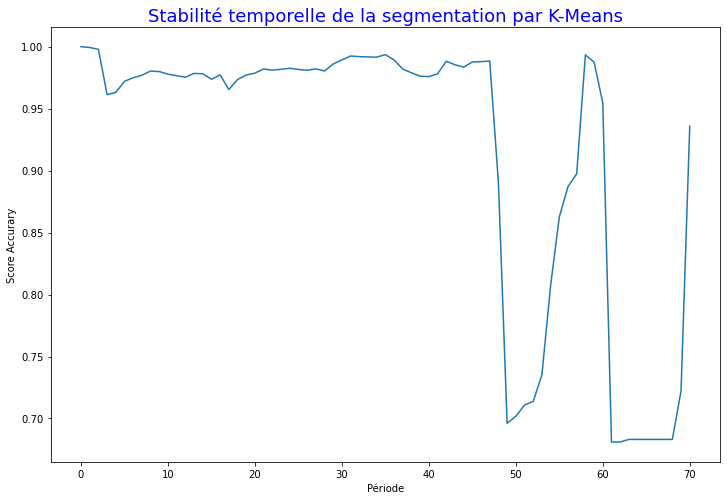

In [26]:
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=df_accuracy, x="periode", y='accuracy')
plt.xlabel("Période")
plt.ylabel("Score Accurary")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Affichons la période temporelle où l'accuracy est en dessous de 0.9:

In [25]:
df_accuracy.loc[df_accuracy['accuracy'] < 0.9].iloc[:5]

,periode,accuracy
48,48,0.890346
49,49,0.696128
50,50,0.701767
51,51,0.710825
52,52,0.713729


Nous obtenons les mêmes résultats quant à la période de de maintenace à savoir après 470 jours.

#### Stabilité des clusters

Nous allons étudier la stabilité dans le temps des clusters de « bons clients »

Affichons les clusters à la fase initiale:

In [10]:
df_intial['cluster_id'] = kmeans_pipeline_init.named_steps['kmeans'].labels_
df_mean = df_intial.groupby('cluster_id').agg({'customer_id': 'count',
                                               'recency': 'mean',
                                               'frequency':'mean',
                                               'monetary':'mean',
                                               'note': 'mean'})
df_mean.columns = ['count', 'recency_mean', 'frequency_mean', 'monetary_mean', 'note_mean']
df_mean

,count,recency_mean,frequency_mean,monetary_mean,note_mean
cluster_id,,,,,
0,32135,441.922421,1.000000,497.317009,4.635195
1,42583,170.933589,1.000000,449.230735,4.672592
2,1574,296.916773,1.031131,10885.279333,3.970140
3,16854,291.514181,1.000000,562.047387,1.593746
4,2945,268.237012,2.115450,1098.704723,4.136076


Ici nos "bons clients" sont dans les clusters 2 et 4:
- Les clients ayant un fort potentiel économique
- Les clients ayant effectués plus d'une commande

Affichons la répartions des clusters juste avant l'inflexion de l'ARI:

In [14]:
date = pd.to_datetime(initial_date) + pd.DateOffset(days=-10*47)
df_p = df_period(df_orders,date)
df_p['cluster_id'] = kmeans_pipeline_init.predict(df_p)
df_mean = df_p.groupby('cluster_id').agg({'customer_id': 'count',
                                          'recency': 'mean',
                                          'frequency':'mean',
                                          'monetary':'mean',
                                          'note': 'mean'})
df_mean.columns = ['count', 'recency_mean', 'frequency_mean', 'monetary_mean', 'note_mean']
df_mean

,count,recency_mean,frequency_mean,monetary_mean,note_mean
cluster_id,,,,,
0,3332,615.424670,1.000000,510.643836,4.632653
1,4897,540.331632,1.000000,529.921817,4.627119
2,157,577.910828,1.006369,13381.747325,4.057325
3,1888,576.665784,1.000000,632.507447,1.573093
4,220,566.195455,2.104545,1271.116545,4.110606


Les clusters 2 et 4 répresentent toujours:
- Les clients ayant un fort potentiel économique
- Les clients ayant effectués plus d'une commande

On aurait donc une stabilité à priori des clusters de « bons clients » dans l'intervalle temps précedent la maintenance.